In [1]:
import numpy as np
import pandas as pd
import os

import time
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn import model_selection, preprocessing, metrics, ensemble
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb

In [2]:
train_df = pd.read_csv("Train.csv")
test_df = pd.read_csv("Test.csv")
submission_df = pd.read_csv("sample_submission.csv")

train_df.head()

,Employee_ID,Gender,Age,Education_Level,Relationship_Status,Hometown,Unit,Decision_skill_possess,Time_of_service,Time_since_promotion,...,Compensation_and_Benefits,Work_Life_balance,VAR1,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7,Attrition_rate
0,EID_23371,F,42.0,4,Married,Franklin,IT,Conceptual,4.0,4,...,type2,3.0,4,0.7516,1.8688,2.0,4,5,3,0.1841
1,EID_18000,M,24.0,3,Single,Springfield,Logistics,Analytical,5.0,4,...,type2,4.0,3,-0.9612,-0.4537,2.0,3,5,3,0.0670
2,EID_3891,F,58.0,3,Married,Clinton,Quality,Conceptual,27.0,3,...,type2,1.0,4,-0.9612,-0.4537,3.0,3,8,3,0.0851
3,EID_17492,F,26.0,3,Single,Lebanon,Human Resource Management,Behavioral,4.0,3,...,type2,1.0,3,-1.8176,-0.4537,NaN,3,7,3,0.0668
4,EID_22534,F,31.0,1,Married,Springfield,Logistics,Conceptual,5.0,4,...,type3,3.0,1,0.7516,-0.4537,2.0,2,8,2,0.1827


In [7]:
train_df.columns

Index(['Employee_ID', 'Gender', 'Age', 'Education_Level',
       'Relationship_Status', 'Hometown', 'Unit', 'Decision_skill_possess',
       'Time_of_service', 'Time_since_promotion', 'growth_rate', 'Travel_Rate',
       'Post_Level', 'Pay_Scale', 'Compensation_and_Benefits',
       'Work_Life_balance', 'VAR1', 'VAR2', 'VAR3', 'VAR4', 'VAR5', 'VAR6',
       'VAR7', 'Attrition_rate'],
      dtype='object')

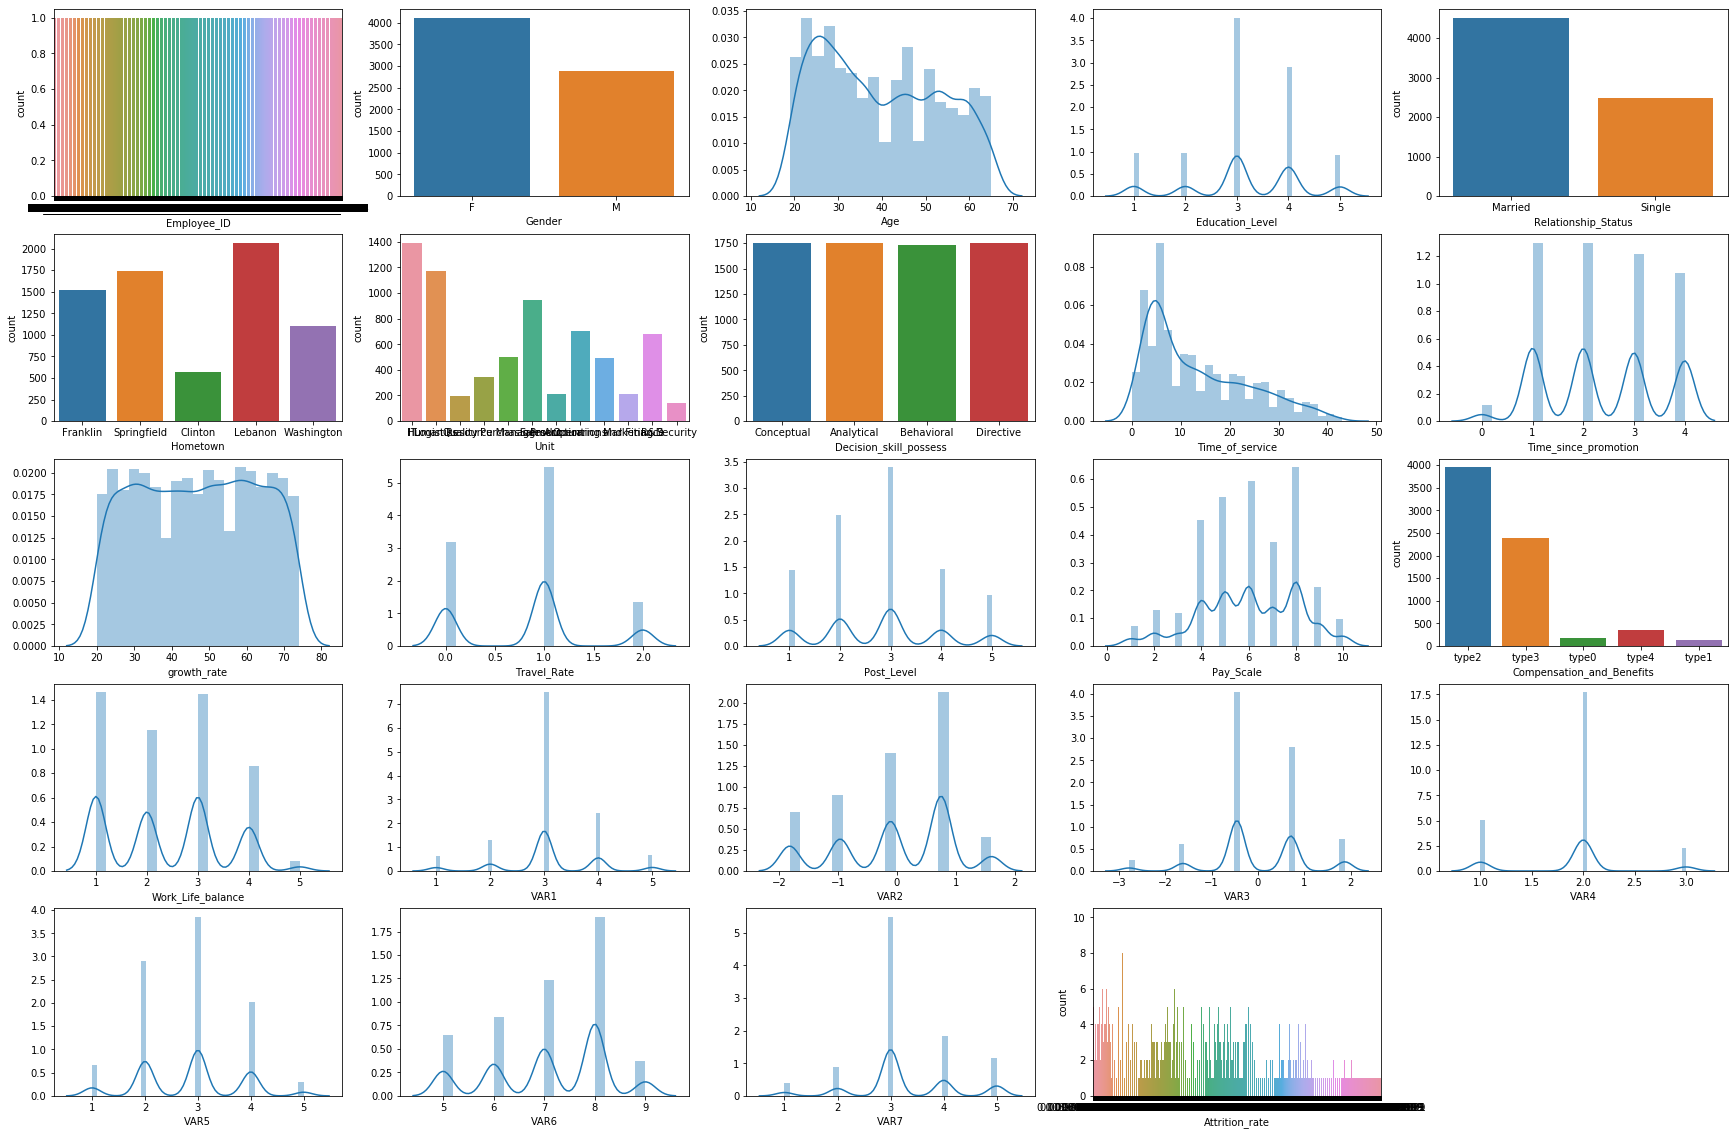

In [19]:
import seaborn as sns
plt.figure(figsize= (30,20))  
pos = 1 
for feature in train_df.columns:   
    plt.subplot(5, 5, pos)   
    if feature in num_cols:   
        sns.distplot(train_df[feature], kde= True )
    else:
        sns.countplot(train_df[feature])
    pos += 1 

In [1]:
train_df.plot(kind= 'box' , subplots=True,layout=(5,5), sharex=False, sharey=False, figsize=(15,10))

NameError: name 'train_df' is not defined

In [ ]:
sns.pairplot(train_df)

In [20]:
train_df.corr()

,Age,Education_Level,Time_of_service,Time_since_promotion,growth_rate,Travel_Rate,Post_Level,Pay_Scale,Work_Life_balance,VAR1,VAR2,VAR3,VAR4,VAR5,VAR6,VAR7,Attrition_rate
Age,1.000000,-0.005770,0.918853,0.145760,0.001270,0.012266,0.002440,0.012966,0.003073,0.005696,0.005406,0.007569,0.001803,0.000015,-0.000832,0.008746,-0.015498
Education_Level,-0.005770,1.000000,-0.012793,-0.002077,0.002991,-0.017690,0.009986,0.006834,-0.015262,-0.002185,-0.010312,-0.009689,0.004500,0.005444,0.009195,0.012909,-0.008143
Time_of_service,0.918853,-0.012793,1.000000,0.137014,-0.003486,0.004843,-0.002286,0.020347,-0.002557,0.004757,0.003858,0.006863,-0.006024,0.003194,0.007618,0.007034,-0.016447
Time_since_promotion,0.145760,-0.002077,0.137014,1.000000,0.014147,-0.012061,-0.008851,-0.008901,-0.007423,-0.002873,0.004211,-0.002783,-0.003724,0.000563,0.017264,0.005173,0.013880
growth_rate,0.001270,0.002991,-0.003486,0.014147,1.000000,0.008460,-0.006887,-0.004145,-0.018324,0.001351,0.010883,0.010991,0.021336,-0.015122,-0.005860,-0.017993,0.014247
Travel_Rate,0.012266,-0.017690,0.004843,-0.012061,0.008460,1.000000,0.021299,-0.011689,0.004132,0.023898,0.008374,-0.009019,-0.005933,-0.003866,-0.012280,-0.006271,-0.012608
Post_Level,0.002440,0.009986,-0.002286,-0.008851,-0.006887,0.021299,1.000000,0.022389,-0.014473,-0.008458,-0.007043,0.010387,-0.012778,0.013008,0.002765,-0.003397,0.016402
Pay_Scale,0.012966,0.006834,0.020347,-0.008901,-0.004145,-0.011689,0.022389,1.000000,-0.022742,0.011354,0.006296,0.003380,-0.010286,0.018080,-0.012318,0.002381,-0.015236
Work_Life_balance,0.003073,-0.015262,-0.002557,-0.007423,-0.018324,0.004132,-0.014473,-0.022742,1.000000,-0.022030,-0.001492,0.004476,-0.026753,0.022196,0.003871,0.024534,0.020746
VAR1,0.005696,-0.002185,0.004757,-0.002873,0.001351,0.023898,-0.008458,0.011354,-0.022030,1.000000,0.002260,-0.003318,0.002112,0.007904,-0.002771,0.009355,-0.008073


In [22]:
cols_for_lbl=['Unit','Hometown','Compensation_and_Benefits',
 'Decision_skill_possess']

In [23]:
for col in cols_for_lbl:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(train_df[col].values.astype('str')) + list(test_df[col].values.astype('str')))
    train_df[col] = lbl.transform(list(train_df[col].values.astype('str')))
    test_df[col] = lbl.transform(list(test_df[col].values.astype('str')))

In [24]:
cols_for_ohe=[
 'Gender',
 'Relationship_Status']

In [25]:
train_df['Gender']=pd.get_dummies(train_df['Gender'])
test_df['Gender']=pd.get_dummies(test_df['Gender'])

train_df['Relationship_Status']=pd.get_dummies(train_df['Relationship_Status'])
test_df['Relationship_Status']=pd.get_dummies(test_df['Relationship_Status'])

